In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing as mp
from stitch import stitch

In [2]:
#Constructing a bump function for nvec_h and nvec_f
def bump(left_n, right_n, center, radius, S):
    left = left_n * np.ones(center - radius)
    right = right_n * np.ones(S - center - radius - 1)
    mean = (left_n + right_n) / 2
    middle = (right_n - mean) * np.sin(np.pi * (np.arange(center - radius, center + radius + 1) - center) / (2 * radius)) + mean
    n_vec = np.concatenate((left, middle, right))
    return n_vec

In [3]:
# Assume Cobb-Douglas. Generalized later. 

# Household parameters
life = 80
S = 80
working = round(9 * S / 16)
beta_annual = .96
beta = beta_annual ** (life / S)

betavec = np.ones(S)

for i in range(1, S):
    betavec[i:] *= beta
    
sigma = 3.0

theta_h = 0.15
theta_f = 0.75

nvec_h = bump(1.0, 0.2, working, 5, S)
nvec_f = bump(1.0, 0.2, working, 5, S)

L_h = np.sum(nvec_h)
L_f = np.sum(nvec_f)

# Firm parameters
Z_h = 1.0
Z_f = 1.0

gamma_h = .35
gamma_f = .35

delta_annual_h = .05
delta_h = 1 - ((1 - delta_annual_h) ** (life / S))

delta_annual_f = .05
delta_f = 1 - ((1 - delta_annual_f) ** (life / S))

# SS parameters
SS_tol = 1e-13
xi = 0.05

In [4]:
@stitch(lambda cvec, sigma: -sigma / (cvec ** (1 + sigma)), (0, None), 1e-10)
def get_MUvec(cvec, sigma):
    return 1 / (cvec ** sigma)

@stitch(lambda x, gamma: gamma / (x ** (1 - gamma)), (0, None), 1e-10)
def root(x, gamma):
    return x ** gamma

def get_Y(K, L, Z, gamma):
    return Z * (K ** gamma) * (L ** (1 - gamma))

def get_K(r, L, Z, P, gamma, delta):
    return (gamma * Z * P * (L ** (1 - gamma)) / (r + delta)) ** (1 / (1 - gamma))

def get_r(K, L, Z, P, gamma, delta):
    return gamma * Z * P * root(K, (gamma - 1)) * root(L, (1 - gamma)) - delta

def get_w(K, L, Z, P, gamma):
    return (1 - gamma) * Z * P * ((K / L) ** gamma)

def get_P(theta, P_1, P_2, e):
    constant = ((1 - theta) ** (1 - theta)) * (theta ** theta)
    return (1 / constant) * root(P_1, (1 - theta)) * root((e * P_2), theta)

In [30]:
#Get the SS values of b_vec_h and b_vec_f

def get_cvec(bvec, nvec, wvec, rvec, Pvec, S, b_init=0):
    #
    #b_vec should be of size S - 1
    #Other vectors should be of size S, or simply scalars if they are the same every period, as in SS.
    #
    #extended_b_vec should be of size S + 1, since it includes the 1st period
    #and the S + 1th period. Borrowing (or saving) in both these periods should be zero, by assumption.
    #
    extended_bvec = np.zeros(S + 1)
    if b_init:
        extended_bvec[0] = b_init
    extended_bvec[1:-1] = bvec
    cvec = (nvec * wvec + (1 + rvec) * extended_bvec[:-1] - extended_bvec[1:]) / Pvec
    return cvec

def r_error(K_h, *args):
    agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f = args
    r_h = get_r(K_h, L_h, Z_h, P_h, gamma_h, delta_h)
    K_f = agg_b - K_h
    r_f = get_r(K_f, L_f, Z_f, P_f, gamma_f, delta_f)
    return abs(r_h - r_f)

def solve_r(*args):
    agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f = args
    K_h_result = opt.minimize_scalar(r_error, bracket=(0, agg_b), args=args, tol=SS_tol)
    if not K_h_result.success:
        print("Minimizer for K_h failed.")
    K_h = K_h_result.x
    K_f = agg_b - K_h
    r = get_r(K_h, L_h, Z_h, P_h, gamma_h, delta_h)
    w_h = get_w(K_h, L_h, Z_h, P_h, gamma_h)
    w_f = get_w(K_f, L_f, Z_f, P_f, gamma_f)
    return K_h, K_f, r, w_h, w_f

def prices_error(prices, *args):
    P_h, P_f, e = prices
    alpha, bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, \
    gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S = args
    
    K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
    
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    cvec_hh = (1 - theta_h) * (P / P_h) * cvec_h
    cvec_hf = theta_h * ((P * e) / P_f) * cvec_h
    cvec_ff = (1 - theta_f) * (P_star / P_f) * cvec_f
    cvec_fh = theta_f * (P_star / (e * P_h)) * cvec_f
    
    Y_h = get_Y(K_h, L_h, Z_h, gamma_h)
    Y_f = get_Y(K_f, L_f, Z_f, gamma_f)
    
    agg_I = delta_f * K_f + delta_h * K_h
    
    error_h = Y_h - np.sum(cvec_hh) - np.sum(cvec_fh) - alpha * agg_I
    error_f = Y_f - np.sum(cvec_hf) - np.sum(cvec_ff) - (1 - alpha) * agg_I
    error_e = P_h * np.sum(cvec_fh) - (P_f / e) * np.sum(cvec_hf)
    
    return (error_h, error_f, error_e)

def V_error(alpha, *args):
    bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, \
    gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S = args
    
    P_h_guess = 1.0
    P_f_guess = 1.0
    e_guess = 1.0
    
    prices_guess = np.array([P_h_guess, P_f_guess, e_guess])
    
    prices_args = (alpha, *args)
    
    prices_result = opt.root(prices_error, prices_guess, args=prices_args, tol=SS_tol)
    if not prices_result.success:
        print("Root finder for prices failed in alpha minimizer.")
        plt.plot(bvec_h)
        plt.show()
        
    P_h, P_f, e = prices_result.x
    
    K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
        
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    V_sum = np.sum((((cvec_h ** (1 - sigma) - 1) / (1 - sigma)) + ((cvec_f ** (1 - sigma) - 1) / (1 - sigma))) * betavec)
    
    return -V_sum

In [31]:
def SS_error(concat_bvec, *args):
    nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, beta, sigma, S = args
    
    bvec_h = concat_bvec[:S - 1]
    
    bvec_f = concat_bvec[S - 1:]
    
    agg_b = np.sum(concat_bvec)
    
    V_args = (bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, \
              gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S)
    
    alpha_result = opt.minimize_scalar(V_error, args=V_args, bounds=(0, 1), method='bounded')
    if not alpha_result.success:
        print("Minimizer for alpha has failed.")
    
    alpha = alpha_result.x
    
    P_h_guess = 1.0
    P_f_guess = 1.0
    e_guess = 1.0
    
    prices_guess = np.array([P_h_guess, P_f_guess, e_guess])
    
    prices_args = (alpha, *V_args)
    
    prices_result = opt.root(prices_error, prices_guess, args=prices_args, tol=SS_tol)
    if not prices_result.success:
        print("Root finder for prices failed.")
    
    P_h, P_f, e = prices_result.x
    
    K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
    
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    MUvec_h = get_MUvec(cvec_h, sigma)
    MUvec_f = get_MUvec(cvec_f, sigma)
    
    error_h = MUvec_h[:-1] - beta * (1 + r) * MUvec_h[1:]
    error_f = MUvec_f[:-1] - beta * (1 + r) * MUvec_f[1:]
    
    return np.concatenate((error_h, error_f))

Root finder for prices failed in alpha minimizer.


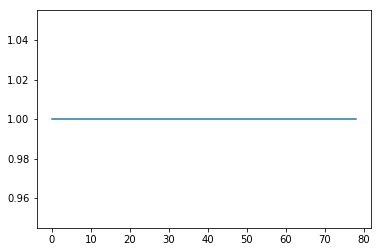

Root finder for prices failed in alpha minimizer.


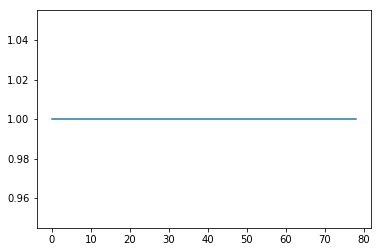

KeyboardInterrupt: 

In [33]:
#Extremely sensitive to initial conditions and parameters.
concat_bvec_guess = np.ones(2 * S - 2) #np.concatenate((bvec_h, bvec_f)) 
SS_args = (nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, beta, sigma, S)
result = opt.root(SS_error, concat_bvec_guess, args=SS_args, tol=SS_tol)
if not result.success:
    print(result)

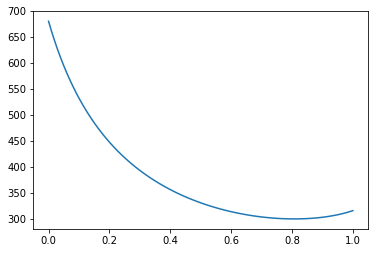

In [13]:
domain = np.linspace(0, 1, 100)
 
concat_bvec = 5 * np.ones(2 * S - 2)

bvec_h = concat_bvec[:S - 1]
    
bvec_f = concat_bvec[S - 1:]
    
agg_b = np.sum(concat_bvec)
    
V_args = (bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, \
          gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S) 
    
plt.plot(domain, [V_error(alpha, *V_args) for alpha in domain])
plt.show()

In [ ]:
#bvec_h = result.x[:S - 1]
#bvec_f = result.x[S - 1:]
#agg_b = np.sum(result.x)
#    
#P_h_guess = 1.0
#P_f_guess = 1.0
#e_guess = 1.0
#
#prices_guess = np.array([P_h_guess, P_f_guess, e_guess])
#
#prices_args = (bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S)
#
#prices_result = opt.root(prices_error, prices_guess, args=prices_args, tol=SS_tol)
#if not prices_result.success:
#    print("Root finder for prices failed.")
#
#P_h, P_f, e = prices_result.x
#
#K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
#    
#P = get_P(theta_h, P_h, P_f, 1 / e)
#P_star = get_P(theta_f, P_f, P_h, e)
#
#cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
#cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
#
#cvec_hh = (1 - theta_h) * (P / P_h) * cvec_h
#cvec_hf = theta_h * ((P * e) / P_f) * cvec_h
#cvec_ff = (1 - theta_f) * (P_star / P_f) * cvec_f
#cvec_fh = theta_f * (P_star / (e * P_h)) * cvec_f
#
#Y_h = get_Y(K_h, L_h, Z_h, gamma_h)
#Y_f = get_Y(K_f, L_f, Z_f, gamma_f)

In [ ]:
def prices_error(prices, *args):
    P_h, P_f, e = prices
    alpha, bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, \
    gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S = args
    
    K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
    
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    cvec_hh = (1 - theta_h) * (P / P_h) * cvec_h
    cvec_hf = theta_h * ((P * e) / P_f) * cvec_h
    cvec_ff = (1 - theta_f) * (P_star / P_f) * cvec_f
    cvec_fh = theta_f * (P_star / (e * P_h)) * cvec_f
    
    Y_h = get_Y(K_h, L_h, Z_h, gamma_h)
    Y_f = get_Y(K_f, L_f, Z_f, gamma_f)
    
    agg_I = delta_f * K_f + delta_h * K_h
    
    error_h = Y_h - np.sum(cvec_hh) - np.sum(cvec_fh) - alpha * agg_I
    error_f = Y_f - np.sum(cvec_hf) - np.sum(cvec_ff) - (1 - alpha) * agg_I
    error_e = P_h * np.sum(cvec_fh) - (P_f / e) * np.sum(cvec_hf)
    
    return (error_h, error_f, error_e)

In [ ]:
def f(alpha):
    bvec_h = result.x[:S - 1]
    bvec_f = result.x[S - 1:]
    agg_b = np.sum(result.x)
        
    P_h_guess = 1.0
    P_f_guess = 1.0
    e_guess = 1.0
    
    prices_guess = np.array([P_h_guess, P_f_guess, e_guess])
    
    prices_args = (alpha, bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S)
    
    prices_result = opt.root(prices_error, prices_guess, args=prices_args, tol=SS_tol)
    if not prices_result.success:
        print("Root finder for prices failed.")
        print(alpha)
    
    P_h, P_f, e = prices_result.x
    
    K_h, K_f, r, w_h, w_f = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)
        
    P = get_P(theta_h, P_h, P_f, 1 / e)
    P_star = get_P(theta_f, P_f, P_h, e)
    
    cvec_h = get_cvec(bvec_h, nvec_h, w_h, r, P, S)
    cvec_f = get_cvec(bvec_f, nvec_f, w_f, r, P_star, S)
    
    return cvec_h, cvec_f

def V_error(alpha):
    #epsilon = 1e-10
    a = f(alpha)
    #b = f(alpha + epsilon)
    #dc_h_dalpha = (b[0] - a[0]) / epsilon
    #dc_f_dalpha = (b[1] - a[1]) / epsilon
    #du_h_dc = get_MUvec(a[0], sigma)
    #du_f_dc = get_MUvec(a[1], sigma)
    #du_h_dalpha = dc_h_dalpha * du_h_dc
    #du_f_dalpha = dc_f_dalpha * du_f_dc
    #dV_h_dalpha = np.sum(du_h_dalpha * betavec)
    #dV_f_dalpha = np.sum(du_f_dalpha * betavec)
    V_sum = np.sum((((a[0] ** (1 - sigma) - 1) / (1 - sigma)) + ((a[1] ** (1 - sigma) - 1) / (1 - sigma))) * betavec)
    return -V_sum #abs(dV_h_dalpha + dV_f_dalpha)

In [ ]:
opt.minimize_scalar(V_error, bounds=(0, 1), method='bounded')

In [ ]:
print(P_h, P_f, e)
print(K_h, K_f, r, w_h, w_f)
print(P, P_star)
print(Y_h, Y_f)

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot((cvec_h ** (1 - sigma) - 1) / (1 - sigma))
plt.plot((cvec_f ** (1 - sigma) - 1) / (1 - sigma))
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(range(S), cvec_hh, label='hh')
plt.plot(range(S), cvec_hf, label='hf')
plt.plot(range(S), cvec_fh, label='fh')
plt.plot(range(S), cvec_ff, label='ff')
plt.legend(fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(range(S-1), bvec_h)
plt.plot(range(S-1), bvec_f)
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(range(S), cvec_h)
plt.plot(range(S), cvec_f)
plt.show()

In [ ]:
#Below is an unsuccessful attempt at an iterative solution.

def bvec_error(bvec, *args):
    nvec, w, r, P, beta, sigma, S = args
    
    cvec = get_cvec(bvec, nvec, w, r, P, S)
    
    MUvec = get_MUvec(cvec, sigma)
    
    error = MUvec[:-1] - beta * (1 + r) * MUvec[1:]
    
    return error

In [ ]:
def get_SS(hh_params, firm_params, ss_params, guess_vec):
    beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f = hh_params
    Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f = firm_params
    SS_tol, xi = ss_params
    old_vec = guess_vec
    iteration = 1
    bvec_h_old = 0.001 * np.ones(S - 1)
    bvec_f_old = 0.001 * np.ones(S - 1)
    P_h, P_f, e, r = old_vec
    
    while True:
        # Find wages using firm's problem
        K_h = get_K(r, L_h, Z_h, P_h, gamma_h, delta_h)
        K_f = get_K(r, L_f, Z_f, P_f, gamma_f, delta_f)
        
        old_agg_b = K_h + K_f
        
        print('old_agg_b: {}'.format(old_agg_b))
    
        w_h = get_w(K_h, L_h, Z_h, P_h, gamma_h)
        w_f = get_w(K_f, L_f, Z_f, P_f, gamma_f)
    
        # Find implied aggregate prices 
        P = get_P(theta_h, P_h, P_f, 1 / e)
        P_star = get_P(theta_f, P_f, P_h, e)
    
        # Solve for savings using Euler Equations
        bvec_h_args = (nvec_h, w_h, r, P, beta, sigma, S)
        bvec_h_result = opt.root(bvec_error, bvec_h_old, args=bvec_h_args, tol=SS_tol)
        if not bvec_h_result.success:
            print("Root finder for bvec_h failed on iteration {}".format(iteration))
            print(bvec_h_result)
            break
        else:
            bvec_h = bvec_h_result.x
            bvec_h_old = bvec_h
    
        bvec_f_args = (nvec_f, w_f, r, P_star, beta, sigma, S)
        bvec_f_result = opt.root(bvec_error, bvec_f_old, args=bvec_f_args, tol=SS_tol)
        if not bvec_f_result.success:
            print("Root finder for bvec_f failed on iteration {}".format(iteration))
            print(bvec_f_result)
            break
        else:
            bvec_f = bvec_f_result.x
            bvec_f_old = bvec_f
    
        agg_b = np.sum(bvec_h + bvec_f)
        
        print('agg_b: {}'.format(agg_b))
    
        prices_guess = (P_h, P_f, e)
        prices_args = (bvec_h, bvec_f, agg_b, nvec_h, nvec_f, L_h, L_f, Z_h, Z_f,
                       gamma_h, gamma_f, delta_h, delta_f, theta_h, theta_f, S)
        prices_result = opt.root(prices_error, prices_guess, args=prices_args, tol=SS_tol)
        if not prices_result.success:
            print("Root finder for prices failed.")
            print(prices_result)
            break
        else:
            P_h, P_f, e = prices_result.x
    
        r = solve_r(agg_b, L_h, L_f, Z_h, Z_f, P_h, P_f, gamma_h, gamma_f, delta_h, delta_f)[2]
    
        # Calculate Euler Error
    
        vec = np.array([P_h, P_f, e, r])
    
        err = np.sum(np.square(old_vec - vec))
        
        if err < 1e-10:
            return old_vec, bvec_h, bvec_f
        else:
            old_vec = xi * vec + (1 - xi) * old_vec
            print(vec)
            P = get_P(theta_h, P_h, P_f, 1 / e)
            P_star = get_P(theta_f, P_f, P_h, e)
            print(P, P_star)
            print("Iteration: ", iteration, "   Error: ", err)
            iteration += 1

In [ ]:
# Parameters
hh_params = (beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f) 
firm_params = (Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f) 
ss_params = (SS_tol, xi)

# Initial guess for P_h, P_f, e, r
P_h_guess = 1.0
P_f_guess = 1.0
e_guess = 1.0
r_guess = 0.05
P_guess = get_P(theta_h, P_h_guess, P_f_guess, 1 / e_guess)
P_star_guess = get_P(theta_f, P_f_guess, P_h_guess, e_guess)
print(P_guess, P_star_guess)

guess_vec = np.array([P_h_guess, P_f_guess, e_guess, r_guess])

prices, bvec_h, bvec_f = get_SS(hh_params, firm_params, ss_params, guess_vec)
P_h, P_f, e, r = prices

In [ ]:
plt.plot(range(S-1), bvec_f)
plt.show()